In [1]:
import torchvision.models as models
import torch
import json
import torch.nn.functional as F

In [18]:
network = models.resnet50(pretrained=True)


In [19]:
from PIL import Image
from torchvision import transforms
input_image = Image.open("samoyed.jpg")
centre_crop = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = centre_crop(input_image)
input_batch = input_tensor.unsqueeze(0) 

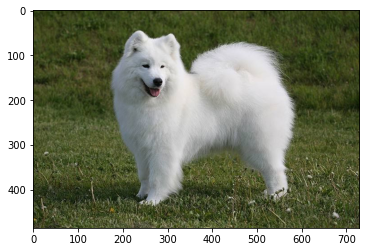

In [20]:
import matplotlib.pyplot as plt 
plt.imshow(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


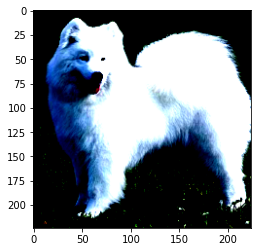

In [21]:
plt.imshow(input_batch[0].permute(1, 2, 0).detach().numpy())

In [22]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    network.to('cuda')


In [37]:
with torch.no_grad():
    network.eval()
    prediction = network(input_batch)  

In [24]:
with open('imagenet1000_clsid_to_human.json') as json_file:
    class_idx = json.load(json_file)
    labels = {int(key): value for key, value in class_idx.items()}


# Returns a Tensor of shape (batch, num class labels)
prediction = prediction.data.numpy().argmax()  # Our prediction will be the index of the class label with the largest value.
print(labels[prediction])
print(prediction)

Samoyed, Samoyede
258


In [11]:
def fast_gradient_attack(image, correct_prediction_index, epsilon, network_to_attack):
    network.eval()
    image.requires_grad = True
    prediction = network_to_attack(image)
    prediction_index = prediction.max(1, keepdim=True)[1]
    print(prediction_index)
    print(prediction_index.shape)

    loss = F.nll_loss(prediction, correct_prediction_index)

    network.zero_grad()
    loss.backward()

    data_grad = image.grad.data


    changed_image = image + epsilon * data_grad.sign()

    changed_image = torch.clamp(changed_image, 0, 1)
    plt.imshow(  changed_image[0].permute(1, 2, 0).detach().numpy()  )
    new_prediction = network_to_attack(changed_image)
    print(labels[new_prediction.data.numpy().argmax()])

tensor([[258]])
torch.Size([1, 1])
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus


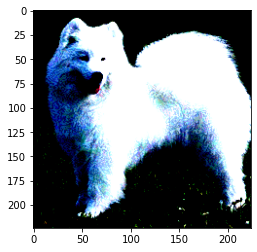

In [12]:
fast_gradient_attack(input_batch, torch.tensor([258]), 0.1, network)

In [56]:
def probabilty_of_class(image, class_index, network):
    #use raw image, it will transform it
    centre_crop = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = centre_crop(image)
    input_batch = input_tensor.unsqueeze(0) 
    with torch.no_grad():
        network.eval()
        prediction = network(input_batch)  
    return prediction.data.numpy()[0,class_index]
    

In [57]:
probabilty_of_class(input_image, 258, network)

13.999283

In [127]:
from tqdm import tqdm

def simba_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1000):
    to_tensor = transforms.ToTensor()
    to_image = transforms.ToPILImage()
    result = to_tensor(image)
    size = result.shape[0] * result.shape[1] * result.shape[2]
    perm = torch.randperm(size)
    prev_prob = probabilty_of_class(to_image(result).convert('RGB'), correct_prediction_index, network_to_attack)
    start_prob = prev_prob
    print(prev_prob)
    for i in tqdm(range(iteration_count)):
        to_add = torch.zeros(size)
        to_add[perm[i]] = epsilon
        to_add = to_add.view(result.size()).clamp(0, 1)
        new_prob = probabilty_of_class(to_image(result + to_add).convert('RGB'), correct_prediction_index, network_to_attack)
        if(new_prob < prev_prob):
            result += to_add
            preb_prob = new_prob
        else:
            new_prob = probabilty_of_class(to_image(result - to_add).convert('RGB'), correct_prediction_index, network_to_attack)
            if(new_prob < prev_prob):
                result -= to_add
                prev_prob = new_prob
    return (to_image(result).convert('RGB'), start_prob, prev_prob) 
    

In [164]:
result = simba_attack(result[0], 258, 0.2, network, 1000)

  0%|          | 1/1000 [00:00<02:06,  7.91it/s]

5.698841


100%|██████████| 1000/1000 [01:19<00:00, 12.56it/s]


5.698841 5.499671


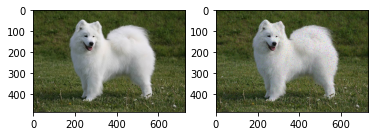

In [168]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(input_image);
ax[1].imshow(result[0]);
print(result[1], result[2])

In [166]:
input_tensor = centre_crop(result[0])
input_batch = input_tensor.unsqueeze(0) 
with torch.no_grad():
    network.eval()
    prediction = network(input_batch)  
prediction = prediction.data.numpy().argmax()
print(labels[prediction])

Arctic fox, white fox, Alopex lagopus
